# Complete analysis for Experiment 3

In [3]:
rm(list= ls())

In [4]:
library(plyr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(BayesFactor)
library(lme4)
library(lmerTest)
library(numform)

## Loading the data

In [5]:
data.folder <- 'Experiment 3'
file.list <- list.files(path= data.folder, pattern= 'csv$')
reports <- data.frame()
for(current.filename in file.list){
    current.observer <- read.csv2(file.path(paste(data.folder, current.filename, sep='/')))
    current.observer$Yellow <- current.observer$Yellow=='True'
    reports <- rbind(reports, current.observer)
}

# Combining a single object trigger and a single switch reports into a single value

reports$Switch.comb <- as.character(reports$Switch)
reports$Switch.comb[reports$Switch.comb %in% c('left', 'right')] <- 'single'
reports$Switch.comb <- factor(reports$Switch.comb, levels = c('neither', 'single', 'both'))
reports$Switch.comb <- plyr::revalue(reports$Switch.comb, c("neither"="no trigger", "single"="single trigger", "both"="double trigger"))


reports$Response.comb <- as.character(reports$Response)
reports$Response.comb[reports$Response.comb %in% c('left', 'right')] <- 'single'
reports$Response.comb <- factor(reports$Response.comb, levels = c('neither', 'single', 'both'))
reports$Response.comb <- plyr::revalue(reports$Response.comb, c("neither"="no switch", "single"="single switch", "both"="double switch"))

# Excluding observers who failed to respond to the exogenous trigger
overall.trigger.efficiency <- reports %>%
    dplyr::filter(Switch!='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))

overly.stable.observers <- overall.trigger.efficiency$Observer[overall.trigger.efficiency$switch.fraction<0.25]
cat('Excluding overly stable participants: ', as.character(overly.stable.observers), '\n')

spontaneous.switch.rate <- reports %>%
    dplyr::filter(Switch=='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))
overly.instable.observers <- spontaneous.switch.rate$Observer[spontaneous.switch.rate$switch.fraction>0.5]

# Also excluding RZN88w due to excessive spontaneous switches
cat('Excluding overly unstable observers: ', as.character(overly.instable.observers), '\n')

reports <- reports[-which(reports$Observer %in% c(as.character(overly.stable.observers), as.character(overly.instable.observers))), ]
reports$Observer <- as.factor(as.character(reports$Observer))

# recomputing for methods after excluding overly stable observers
overall.trigger.efficiency <- reports %>%
    dplyr::filter(Switch!='neither') %>%
    dplyr::group_by(Observer) %>%
    dplyr::summarize(switch.fraction= mean(Response!='neither'))

overall.trigger.efficiency

summary(overall.trigger.efficiency$switch.fraction)

Excluding overly stable participants:  ACR94m BBW97w 
Excluding overly unstable observers:  RZN88w 


Observer,switch.fraction
ASA97w,0.7351351
AZM90w,0.6322751
ERK91m,0.7823834
MCB93w,0.7275132
NSM89w,0.7406417
SBS92w,0.5243243
SGP95w,0.3797814
SGS95w,0.7394737
SJW88m,0.4701087


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3798  0.5243  0.7275  0.6368  0.7395  0.7824 

### Computing proprtion of reports of all kinds (`neither`, `single`, and `both`; columns) vs. type of the exogenous trigger (`neither`, `single`, and `both`; rows)

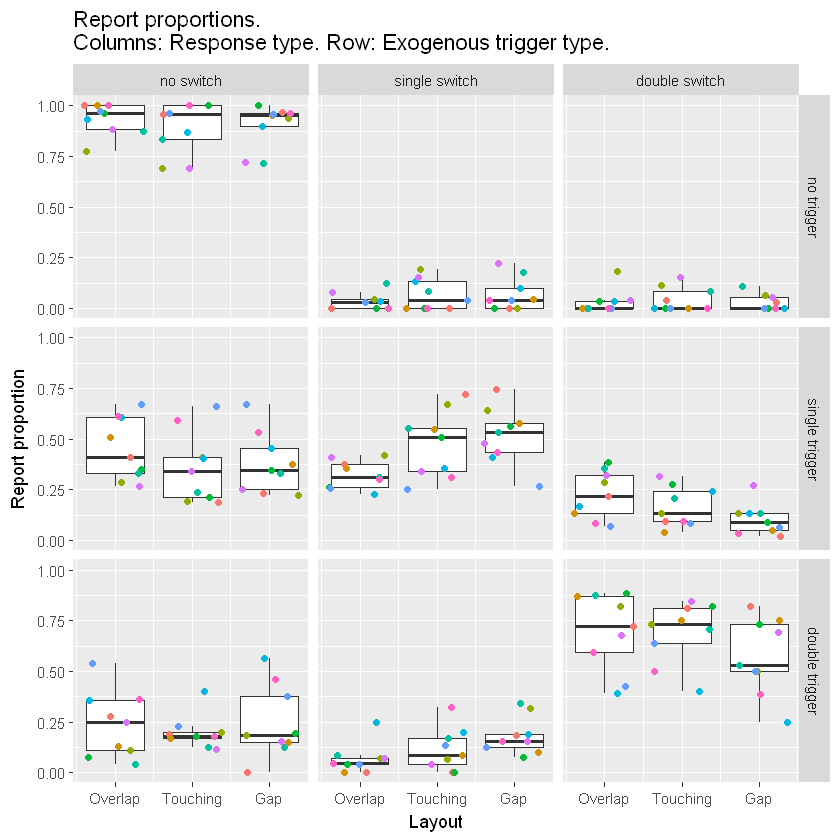

In [6]:
trigger.count <- reports %>%
    dplyr::group_by(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(response.count= n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::mutate(response.count= ifelse(is.na(response.count), 0, response.count)) %>%
    dplyr::group_by(Observer, Gap, Switch.comb) %>%
    dplyr::mutate(report.proportion= response.count/sum(response.count))

proportion.plot <- ggplot(data= trigger.count, aes(x= Gap, group= Gap, y= report.proportion, color= Observer))+
    geom_boxplot(outlier.shape = NA) +
    geom_jitter(aes(color= Observer)) +
    xlab('Layout') +
    ylab('Report proportion')+
    theme(legend.position='none') +
    facet_grid(Switch.comb ~ Response.comb)+
    ggtitle('Report proportions.\nColumns: Response type. Row: Exogenous trigger type.')+
    scale_x_continuous(breaks = c(sort(unique(trigger.count$Gap))), labels = c('Overlap', 'Touching', 'Gap'))
print(proportion.plot)
# ggsave('Exp2 - trigger vs report.pdf')

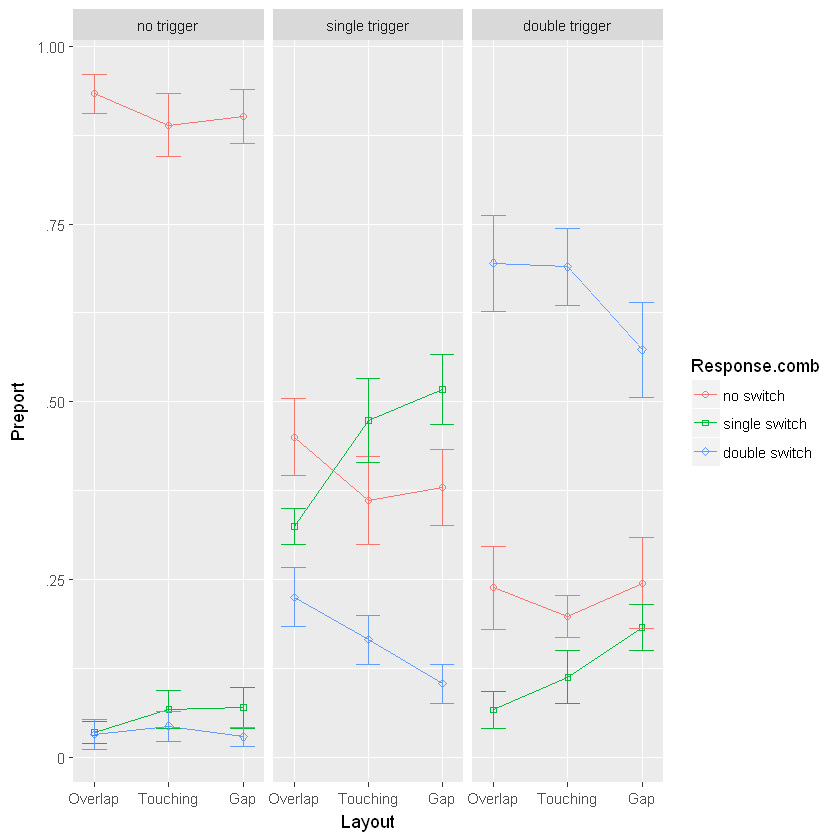

In [7]:
group.trigger.count <- reports %>%
    dplyr::group_by(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(response.count= n()) %>%
    dplyr::ungroup() %>%
    tidyr::complete(Observer, Switch.comb, Gap, Response.comb) %>%
    dplyr::mutate(response.count= ifelse(is.na(response.count), 0, response.count)) %>%
    dplyr::group_by(Observer, Gap, Switch.comb) %>%
    dplyr::mutate(report.proportion= response.count/sum(response.count)) %>%
    dplyr::group_by(Switch.comb, Gap, Response.comb) %>%
    dplyr::summarize(P.report= mean(report.proportion), 
                     P.serr= sd(report.proportion)/sqrt(n()-1))

proportion.plot <- ggplot(data= group.trigger.count, aes(x= Gap, 
                                                         y= P.report, ymin= P.report-P.serr, ymax= P.report+P.serr,
                                                         color= Response.comb, shape= Response.comb))+
    geom_line() +
    geom_point() +
    geom_errorbar(width=0.05) + 
    xlab('Layout') +
    ylab('Preport')+
#     theme(legend.position='none') +
    facet_grid(. ~ Switch.comb)+
#     ggtitle('Report proportions.\nColumns: Response type. Row: Exogenous trigger type.')+
    scale_x_continuous(breaks = c(sort(unique(trigger.count$Gap))), labels = c('Overlap', 'Touching', 'Gap'))+
    scale_y_continuous(labels = numform::ff_num(zero = 0, digits= 2))+
    theme(panel.grid.minor.x=element_blank())+
    scale_shape_manual(values=c(21, 22, 23))


print(proportion.plot)
ggsave('Exp2 - proportion plot.pdf', proportion.plot, width= 16, height= 8, units = 'cm')
# ggsave('Exp2 - trigger vs report.pdf')

### Given the _no_ visible dependence of reports on the layout, testing whether gap has an effect on the overall probability of the switch
Using only __neither__ reports and __single__ and __both__ trigger types

In [8]:
rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

In [9]:
neither.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='no switch') & (Switch.comb!='no trigger'))

lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= neither.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
neither.report.anova <-  anova(lm.null, lm.trigger, lm.layout, lm.interaction)
neither.report.anova
neither.report.anova$'Pr(>Chisq)'


lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap + Switch.comb + (1|Observer), data= neither.reports))

coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-45.97468,-40.00773,25.98734,-51.97468,NA,NA,NA
lm.trigger,4,-76.55662,-68.60069,42.27831,-84.55662,32.581939,1,1.142717e-08
lm.layout,5,-75.71497,-65.77005,42.85749,-85.71497,1.158351,1,2.818077e-01
lm.interaction,6,-75.43441,-63.50051,43.71721,-87.43441,1.719438,1,1.897654e-01


[1]           NA 1.142717e-08 2.818077e-01 1.897654e-01

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.3968722,0.04564831,9.317698,8.694127,9.026304e-06,0.9435349
-0.1700089,0.02482739,43.000102,-6.847636,2.139432e-08,0.7222448
-0.1073258,0.10135739,43.000102,-1.058885,2.955642e-01,0.1594133


### Given the _positive_ dependence of the `single` reports  on the layout, testing for its significance
Using only __single__ reports and __single__ and __both__ trigger types

In [10]:
2.955642e-01

[1] 0.2955642

In [11]:
single.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='single switch') & (Switch.comb!='no trigger'))
lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= single.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
single.report.anova <- anova(lm.null, lm.trigger, lm.layout, lm.interaction)
single.report.anova
single.report.anova$'Pr(>Chisq)'

lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap +  (1|Observer), data= single.reports))

lmer.report
coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-12.89391,-6.926957,9.446954,-18.89391,NA,NA,NA
lm.trigger,4,-62.23421,-54.278273,35.117104,-70.23421,51.340300,1,7.766481e-13
lm.layout,5,-76.56593,-66.621013,43.282966,-86.56593,16.331724,1,5.316640e-05
lm.interaction,6,-75.80471,-63.870810,43.902357,-87.80471,1.238781,1,2.657061e-01


[1]           NA 7.766481e-13 5.316640e-05 2.657061e-01

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: report.proportion ~ Switch.comb + Gap + (1 | Observer)
   Data: single.reports

REML criterion at convergence: -72.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.92114 -0.69575 -0.09186  0.58083  2.39786 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.001407 0.03752 
 Residual             0.011379 0.10667 
Number of obs: 54, groups:  Observer, 9

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.43858    0.02404 18.68000  18.245 2.33e-13 ***
Switch.combdouble trigger -0.31813    0.02903 43.00000 -10.957 5.02e-14 ***
Gap                        0.51411    0.11853 43.00000   4.337 8.56e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Swtc.t
Swtch.cmbdt -0.604       
Gap      

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.4385839,0.02403839,18.67539,18.245143,2.333689e-13,0.9730769
-0.3181264,0.02903306,43.00007,-10.957383,5.018208e-14,0.8580792
0.5141099,0.11852697,43.00007,4.337493,8.557493e-05,0.5516906


The analysis shows that the smaller gap produces fewer __single__ switch responses (highly significant _positive_ slope for `Gap`) and that there were fewer __single__ switch responses for when the exogenous trigger was applied to __both__ spheres (highly significant negative factor for `Switch.combboth`). However, there is no evidence for the interaction.

### Given the _negative_ dependence of the `both` reports  on the layout, testing for its significance
Using only __both__ reports and __single__ and __both__ trigger types

In [12]:
both.reports <- trigger.count %>%
    dplyr::filter((Response.comb=='double switch') & (Switch.comb!='no trigger'))

lm.null <- lme4::lmer(report.proportion ~ 1 + (1|Observer), data= both.reports, REML= FALSE)
lm.trigger <- update(lm.null, .~. + Switch.comb)
lm.layout <- update(lm.trigger, .~. + Gap)
lm.interaction <- update(lm.layout, .~. + Switch.comb * Gap)
both.report.anova <- anova(lm.null, lm.trigger, lm.layout, lm.interaction)
both.report.anova
both.report.anova$Chisq
both.report.anova$'Pr(>Chisq)'

lmer.report <- summary(lmerTest::lmer(report.proportion ~ Switch.comb + Gap  + (1|Observer), data= both.reports))

lmer.report
coefficients.only <- data.frame(summary(lmer.report)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,23.41067,29.37762,-8.705336,17.41067,NA,NA,NA
lm.trigger,4,-55.77067,-47.81473,31.885334,-63.77067,8.118134e+01,1,2.059273e-19
lm.layout,5,-64.26091,-54.31599,37.130453,-74.26091,1.049024e+01,1,1.200068e-03
lm.interaction,6,-62.26093,-50.32703,37.130467,-74.26093,2.701277e-05,1,9.958531e-01


[1]           NA 8.118134e+01 1.049024e+01 2.701277e-05

[1]           NA 2.059273e-19 1.200068e-03 9.958531e-01

Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: report.proportion ~ Switch.comb + Gap + (1 | Observer)
   Data: both.reports

REML criterion at convergence: -61.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.05792 -0.65488  0.09078  0.64489  1.79089 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.008506 0.09223 
 Residual             0.011873 0.10896 
Number of obs: 54, groups:  Observer, 9

Fixed effects:
                          Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                0.16454    0.03721 11.23000   4.422 0.000976 ***
Switch.combdouble trigger  0.48814    0.02966 43.00000  16.460  < 2e-16 ***
Gap                       -0.40678    0.12107 43.00000  -3.360 0.001643 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr) Swtc.t
Swtch.cmbdt -0.398       
Gap        

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.1645439,0.03721431,11.23018,4.421523,0.0009762101,0.7969613
0.4881353,0.02965631,43.00007,16.459745,0.0000000000,0.9289907
-0.4067840,0.12107137,43.00007,-3.359870,0.0016434762,0.4560026


The analysis shows that the smaller gap produces more __both__ switch responses (significant _negative_ slope for `Gap`) and that there were fewer __both__ switch responses for when the exogenous trigger was applied to a __single__ sphere only (highly significant positive factor for `Switch.combboth`). However, there is no evidence for the interaction.

Analysis shows that there were more reported switch when the exogenous trigger was applied to __both__ spheres (highly significant _negative_ effect for the `Switch.combboth` means that there were fewer 'no switch' responses, hence, more 'switch responses'). However, there was neither an effect of the `Gap`, nor of `Switch` x `Gap` interaction.

## Looking at the effect of the trigger timing

SwitchTime,P.switch,P.serr
1.1,0.3514591,0.05812369
1.3,0.3437760,0.04567837
1.5,0.3648883,0.05804399
1.7,0.3522123,0.05282676
1.9,0.4088545,0.05072543


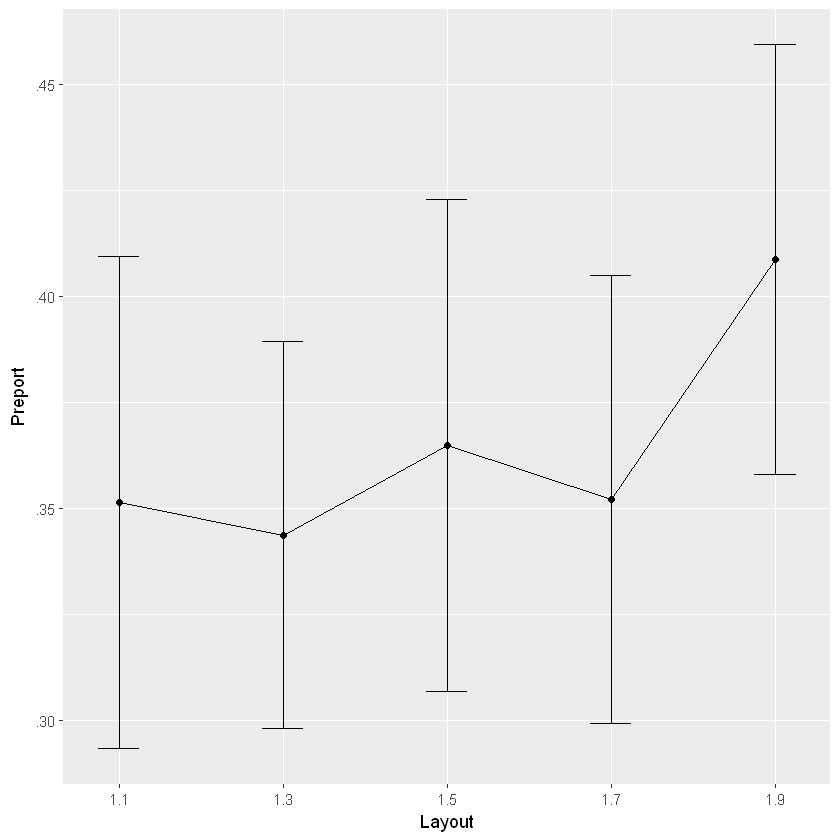

In [13]:
trigger.timing.effect <- reports %>%
    dplyr::filter(Switch.comb != 'no trigger') %>%
    dplyr::group_by(Observer, SwitchTime) %>%
    dplyr::summarize(switch.proportion= mean(Response.comb=='no switch')) %>%
    dplyr::group_by(SwitchTime) %>%
    dplyr::summarize(P.switch= mean(switch.proportion), 
                     P.serr= sd(switch.proportion)/sqrt(n()-1))
trigger.timing.effect

proportion.plot <- ggplot(data= trigger.timing.effect, aes(x= SwitchTime, 
                                                         y= P.switch, ymin= P.switch-P.serr, ymax= P.switch+P.serr))+
    geom_line() +
    geom_errorbar(width=0.05) + 
    geom_point() +
    xlab('Layout') +
    ylab('Preport')+
    scale_x_continuous(breaks = c(sort(unique(trigger.timing.effect$SwitchTime))))+
    scale_y_continuous(labels = numform::ff_num(zero = 0, digits= 2))+
    theme(panel.grid.minor.x=element_blank())

print(proportion.plot)
# ggsave('Exp2 - proportion plot.pdf', proportion.plot, width= 16, height= 8, units = 'cm')
# ggsave('Exp2 - trigger vs report.pdf')